## 02 - Accounting for Subscriptions/Redemptions/Fees -> P/L
Once I have all my portfolio transactions recorded, I want to understand how much I am gaining.

In the table below I reported the amounts I want to track to understand my Portfolio Profit/Loss.

#### Portfolio Profit/Loss
| Incomes | Costs |
|---------------|------------------|
| (Current) Market_Value | Subscriptions |
| Redemptions | Commissions |
| Dividends | Taxes |

Portfolio **Profit (Loss) = Incomes - Costs**

**Objective:**

In this notebook, I will calculate:
- the Profit and Loss (P/L) of the portfolio and of each individual asset.

**Some glossary**
- (Current) `Market_Value` = (`Shares` held) x (Current `Price`) of each asset.
- `Redemptions` represent the cumulative capital outflows (`Amount`) from the sale or liquidation of an asset.
- `Dividends` represent cash dividends (`Amount`) eventually received.
- `Subscriptions` represent the cumulative capital inflows (`Amount`) allocated to purchase an asset.
- `Commissions` and `Taxes` account for the cumulative transactional costs.

In [1]:
# import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
plt.style.use('ggplot')

In [3]:
# importing the function to load transactions from utils.py
from utils import load_transactions

I load my portfolio transactions:

In [4]:
excel_path = '../data/transactions_carlo.xlsx'
df_transacts = load_transactions(excel_path=excel_path, sheet_name=0)

#### A. Calculation of Portfolio Profit and Loss (P/L).

I calculate **Current** Portfolio P/L as: $$\text{Portfolio P/L} = \text{Current Market Value} + \text{Total Redemptions} + \text{Total Dividends} - \text{Total Costs}$$ where $$\text{Total Costs} = \text{Total Subscriptions} + \text{Total Commissions} + \text{Total Taxes}$$

Therefore Current *Portfolio Total Return (%)* = $\frac{\text{Portfolio P/L}}{\text{Total Costs}}$



The current value of each TICKER is estimated using two different price references:
- the midpoint of the intraday range, calculated as the average between the High and Low prices;
- the official Closing price at the end of the trading day.

Similarly, per each TICKER I calculated the Current Total Return (%) as:

$$\text{Total Return} = \frac{\text{Current Market Value} + \text{Total Redemptions} + \text{Total Dividends}}{\text{Total Costs}} -1$$

Per each of the variables `Subscriptions`, `Redemptions`, `Dividends`, (transactional) `Costs`, and `Shares` held, I create one `pd.Series` indexed on the Tickers: 

In [5]:
# Step 0: Get all tickers
all_tickers = df_transacts['Ticker'].unique()

# 1. Total Subscriptions (only 'BUY')
subs = df_transacts[df_transacts['Type'] == 'BUY'].groupby('Ticker')['Amount'].sum()
subs.name = 'Subscriptions'

# 2. Total Redemptions ('SELL' as positive inflows)
redemps = df_transacts[df_transacts['Type'] == 'SELL'].groupby('Ticker')['Amount'].sum().abs()
redemps.name = 'Redemptions'

# 3. Total Dividends
div = df_transacts[df_transacts['Type'] == 'Dividend'].groupby('Ticker')['Amount'].sum().abs()
div.name = 'Dividends'

# 4. Total Costs
costs = df_transacts.groupby('Ticker')[['Commissions', 'Taxes']].sum().sum(axis=1)
costs.name = 'Costs'

# 5. Current shares held
shares = df_transacts.groupby('Ticker')['Shares'].sum()
shares.name = 'Current_Shares'

With the same logic I fetch the *Current Price* of eack Ticker and create the `pd.Series` `prices` and `close_dates` also indexed on the Tickers.

*Note*. I append the suffix `'.MI'` to tickers for market identification, that in this case is Borsa Italiana (`'.MI'`).

In [6]:
price_ref = 'close'
# 6. Prices and date (batch fetch)
tickers_full = [t + '.MI' for t in all_tickers]
price_data = yf.download(tickers_full, period='1d', group_by='ticker', progress=False, auto_adjust=True)

prices = {}
dates = {}
for t in all_tickers:
    label = t + '.MI'
    if price_ref == 'close':
        val = price_data[label]['Close'].iloc[0]
    elif price_ref == 'intraday_range':
        val = price_data[label][['High', 'Low']].mean(axis=1).iloc[0]
    prices[t] = val
    dates[t] = price_data.index[0].strftime('%Y-%m-%d')

prices = pd.Series(prices, name='Last_Price')
close_dates = pd.Series(dates, name='Last_Date')

Then I combine evrything using `pd.concat()` set by default on `join = 'outer'`:

In [7]:
# 7. Combine everything
pf_pl = pd.concat([shares, subs, redemps, div, costs, prices, close_dates], axis=1).fillna(0)
pf_pl['Market_Value'] = pf_pl['Current_Shares'] * pf_pl['Last_Price']
pf_pl['Total Return (%)'] = ((pf_pl['Market_Value'] + pf_pl['Redemptions'] + pf_pl['Dividends'])/ \
    (pf_pl['Subscriptions'] + pf_pl['Costs'])
    - 1) * 100

pf_pl.round(2)

,Current_Shares,Subscriptions,Redemptions,Dividends,Costs,Last_Price,Last_Date,Market_Value,Total Return (%)
CSSPX,84,38147.08,0.00,0.0,26.00,566.11,2025-05-16,47553.24,24.57
EM710,201,31435.81,0.00,0.0,25.18,168.01,2025-05-16,33770.01,7.34
ITPS,145,30898.87,0.00,0.0,19.36,221.12,2025-05-16,32062.40,3.70
PHAU,129,28636.15,12276.87,0.0,34.00,265.77,2025-05-16,34284.33,62.40


From the `pf_pl` DataFrame I can calculate the total Subscriptions, Redemptions, Commissions, Taxes, Dividends and Portfolio Current_Value:

In [8]:
pf_summary = pf_pl[['Subscriptions','Redemptions','Dividends','Costs','Market_Value']].sum()
pf_summary

Subscriptions    129117.91000
Redemptions       12276.87000
Dividends             0.00000
Costs               104.54000
Market_Value     147669.97554
dtype: float64

With these data I can calculate the Current *Portfolio P/L* and the *Portfolio Total Return (%)*:

In [9]:
print('Portfolio Total Profit (Loss): ',
      round((pf_summary.Market_Value + pf_summary.Redemptions + pf_summary.Dividends 
             - pf_summary.Costs - pf_summary.Subscriptions),2))

print('Portfolio Total Return (%):',
      round(((pf_summary.Market_Value + pf_summary.Redemptions + pf_summary.Dividends)/
             (pf_summary.Subscriptions + pf_summary.Costs) -1)*100,2))

Portfolio Total Profit (Loss):  30724.4
Portfolio Total Return (%): 23.78


I can wrap the code to calculate Current Portfolio P/L by Ticker in the function `portfolio_pl()` for reuse:

In [10]:
def portfolio_pl(transactions: pd.DataFrame, market_suffix:str = '.MI', price_ref: str = 'close') -> pd.DataFrame:
    """
    Calculate portfolio-level Profit & Loss (P/L) per Ticker.

    Parameters:
    -----------
    transactions : pd.DataFrame
        DataFrame of portfolio transactions with at least the following columns:
        ['Ticker', 'Type', 'Amount', 'Shares', 'Commissions', 'Taxes']
        
    market_suffix : str
        Suffix to append to tickers for market identification: '.MI' (default) for Borsa Italiana
        
    price_ref : str
        Method to calculate price: 'close' (default) or 'intraday_range' (mean of high and low)

    Returns:
    --------
    pd.DataFrame
        Portfolio P/L per ticker with last available price date as index.
    """
    # Step 0: Get all tickers
    all_tickers = transactions['Ticker'].unique()

    # 1. Total Subscriptions (only 'BUY')
    subs = transactions[transactions['Type'] == 'BUY'].groupby('Ticker')['Amount'].sum()
    subs.name = 'Subscriptions'

    # 2. Total Redemptions ('SELL' as positive inflows)
    redemps = transactions[transactions['Type'] == 'SELL'].groupby('Ticker')['Amount'].sum().abs()
    redemps.name = 'Redemptions'

    # 3. Total Dividends
    div = transactions[transactions['Type'] == 'Dividend'].groupby('Ticker')['Amount'].sum().abs()
    div.name = 'Dividends'

    # 4. Total Costs (Commissions + Taxes)
    costs = transactions.groupby('Ticker')[['Commissions', 'Taxes']].sum().sum(axis=1)
    costs.name = 'Costs'

    # 5. Current shares held
    shares = transactions.groupby('Ticker')['Shares'].sum()
    shares.name = 'Current_Shares'

    # 6. Prices and last date
    tickers_full = [t + market_suffix for t in all_tickers]
    price_data = yf.download(tickers_full, period='1d', group_by='ticker', progress=False, auto_adjust=True)

    prices = {}
    dates = {}
    for t in all_tickers:
        label = t + market_suffix
        if price_ref == 'close':
            val = price_data[label]['Close'].iloc[0]
        elif price_ref == 'intraday_range':
            val = price_data[label][['High', 'Low']].mean(axis=1).iloc[0]
        else:
            raise ValueError("price_ref must be 'close' or 'intraday_range'")
        prices[t] = val
        dates[t] = price_data.index[0].strftime('%Y-%m-%d')

    prices = pd.Series(prices, name='Last_Price')
    close_dates = pd.Series(dates, name='Last_Date')

    # 7. Combine everything and compute P/L
    pf_pl = pd.concat([shares, subs, redemps, div, costs, prices, close_dates], axis=1).fillna(0)

    pf_pl['Market_Value'] = pf_pl['Current_Shares'] * pf_pl['Last_Price']
    pf_pl['Total Return (%)'] = (
        (pf_pl['Market_Value'] + pf_pl['Redemptions'] + pf_pl['Dividends'])/
        (pf_pl['Subscriptions'] + pf_pl['Costs']) - 1) * 100

    return pf_pl


In [11]:
# Example usage of portfolio_pl() function
price_ref='close'
df_pl = portfolio_pl(transactions=df_transacts, price_ref=price_ref)
print(f'Portfolio Current P/L by Ticker at {price_ref} price as of {df_pl.Last_Date.unique()[0]}:\n')
df_pl.round(2)

Portfolio Current P/L by Ticker at close price as of 2025-05-16:



,Current_Shares,Subscriptions,Redemptions,Dividends,Costs,Last_Price,Last_Date,Market_Value,Total Return (%)
CSSPX,84,38147.08,0.00,0.0,26.00,566.11,2025-05-16,47553.24,24.57
EM710,201,31435.81,0.00,0.0,25.18,168.01,2025-05-16,33770.01,7.34
ITPS,145,30898.87,0.00,0.0,19.36,221.12,2025-05-16,32062.40,3.70
PHAU,129,28636.15,12276.87,0.0,34.00,265.77,2025-05-16,34284.33,62.40


I can embed the function `portfolio_pl()` and calculate the Current Portfolio summary in the function `portfolio_summary()` for reuse:

In [12]:
def portfolio_summary(transactions: pd.DataFrame, market_suffix: str = '.MI',
                      price_ref: str = 'close') -> pd.Series:
    """
    Generate a summary of the overall portfolio from the transactions DataFrame.

    Parameters:
    -----------
    transactions : pd.DataFrame
        DataFrame of portfolio transactions with at least the following columns:
        ['Ticker', 'Type', 'Amount', 'Shares', 'Commissions', 'Taxes']
    
    market_suffix : str
        Suffix to append to tickers for market identification: '.MI' (default) for Borsa Italiana
        
    price_ref : str
        Method to calculate price: 'close' (default) or 'intraday_range' (mean of high and low)
        
    Returns:
    --------
    pd.Series
        A Series summarizing Subscriptions, Redemptions, Dividends, Costs, and Current Value.
    """
    pf_pl = portfolio_pl(transactions, market_suffix = market_suffix, price_ref=price_ref)
    
    summary = pf_pl[['Subscriptions', 'Redemptions', 'Dividends', 'Costs', 'Market_Value']].sum()
    summary['Profit (Loss)'] = summary.Market_Value + summary.Redemptions + summary.Dividends\
        - summary.Costs - summary.Subscriptions
    summary['Total Return (%)'] = (summary['Profit (Loss)'] / (summary.Subscriptions + summary.Costs)) * 100
    
    return summary

In [13]:
# Example usage of portofolio_summary() function
price_ref='close'
df_summary = portfolio_summary(transactions=df_transacts, price_ref=price_ref)

print(f'Portfolio Summary at {price_ref} price as of {df_pl.Last_Date.unique()[0]}:\n')
df_summary.round(2)

Portfolio Summary at close price as of 2025-05-16:



Subscriptions       129117.91
Redemptions          12276.87
Dividends                0.00
Costs                  104.54
Market_Value        147669.98
Profit (Loss)        30724.40
Total Return (%)        23.78
dtype: float64

Notice that the *Portfolio Total Return (%)* is the weighted average of each Ticker's `Total Return (%)`, where each Ticker's weight is the proportion of the `Subscriptions` + `Costs` for that Ticker, relative to the *Total Subscriptions + Costs* of the Portfolio.

#### B. Current Asset Allocation (time t = today).

Helps visualizing the deviations from planned asset allocation and taking action to rebalance every 6 or 12 months.

In [14]:
# strategy asset allocation
strategy_percentages = [34,22,22,22]

# select the series with assets currently held and current values
current_allocation = pf_pl[pf_pl['Current_Shares']!=0]['Market_Value']
current_allocation

CSSPX    47553.238770
EM710    33770.008896
ITPS     32062.399292
PHAU     34284.328583
Name: Market_Value, dtype: float64

I can directly wrap the code in the function `compare_asset_allocation()`:

In [15]:
def compare_asset_allocation(current_allocation: pd.Series, strategy_percentages: list, 
                             strategy_labels: list, title_date: str = ''):
    """
    Compare current and strategic asset allocation using pie charts.

    Parameters:
    -----------
    current_allocation : pd.Series
        Series with tickers as index and current value as values.
        
    strategy_percentages : list
        List of planned allocation percentages in the same order as tickers.
        
    strategy_labels : list
        List of tickers or asset names matching the order in strategy_percentages.
        
    title_date : str
        Optional date string to annotate current allocation chart.
    """
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    ax[0].pie(current_allocation, labels=current_allocation.index,
              autopct='%1.1f%%', pctdistance=1.25, labeldistance=0.6)
    ax[0].set_title(f'Current Asset Allocation {f"({title_date})" if title_date else ""}')

    ax[1].pie(strategy_percentages, labels=strategy_labels,
              autopct='%1.1f%%', pctdistance=1.25, labeldistance=0.6)
    ax[1].set_title('Strategy (Planned) Asset Allocation')

    plt.tight_layout()
    plt.show()

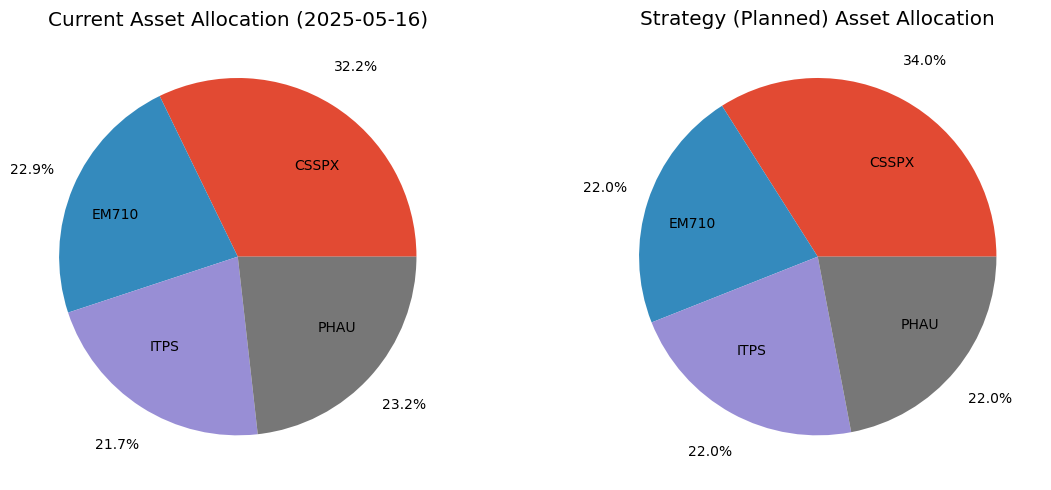

In [16]:
# Example usage of the function compare_asset_allocation()
compare_asset_allocation(current_allocation = current_allocation,
                         strategy_percentages = strategy_percentages,
                         strategy_labels= current_allocation.index,
                         title_date = df_pl['Last_Date'].iloc[0])

#### C. Rebalancing Instructions (if it's time to rebalance)
To conclude this notebook, I define a function that calculates the number of `'Shares_To_Trade'`—either to BUY or SELL—for each asset in order to rebalance the portfolio according to the target asset allocation strategy.
One of the inputs to this function is the DataFrame containing the current portfolio performance by ticker, referred to as `df_pl` in the previous sections.

In [17]:
def calculate_rebalance(current_portfolio_data, strategy_percentages, amount_invest=0):
    """
    Calculate the number of shares to buy or sell for each asset to reach target portfolio weights.

    Parameters:
    -----------
    current_portfolio_data : pd.DataFrame
        A DataFrame containing at least the following columns:
        - 'Current_Shares': current number of shares held
        - 'Market_Value' : current market value of the position
        - 'Last_Price'   : latest price per share
        The DataFrame index should contain asset tickers.

    strategy_percentages : list of float
        Target allocation weights as percentages for each asset, in the same order as current_portfolio_data.

    amount_invest : float, optional (default=0)
        Additional capital to invest during rebalancing.

    Returns:
    --------
    pd.DataFrame
        A DataFrame including:
        - 'Current_Shares'
        - 'Target_Shares'
        - 'Shares_To_Trade': positive means buy, negative means sell

    Also prints:
    ------------
    A list of assets and the number of shares to buy/sell to reach target allocation.
    """
    # Extract and copy relevant columns
    allocation = current_portfolio_data.loc[:, ['Current_Shares', 'Market_Value', 'Last_Price']].copy()

    # Total portfolio value including additional investment
    total_value = allocation['Market_Value'].sum() + amount_invest

    # Calculate target values and shares
    target_weights = np.array(strategy_percentages) / 100
    allocation['Target_Value'] = total_value * target_weights
    allocation['Target_Shares'] = (allocation['Target_Value'] // allocation['Last_Price']).astype(int)
    allocation['Shares_To_Trade'] = allocation['Target_Shares'] - allocation['Current_Shares']

    return allocation[['Current_Shares', 'Target_Shares', 'Shares_To_Trade']]

In [18]:
# example usage of calculate_rebalance() function when rebalance is required
# stratey_percentages defined in section B assuming same order as df_pl index
add_investment = 0 # eventual additional money to invest

print('Rebalance Instructions (Shares to Trade) when rebalance is required:\n')
calculate_rebalance(current_portfolio_data=df_pl,
                    strategy_percentages=strategy_percentages,
                    amount_invest=add_investment)

Rebalance Instructions (Shares to Trade) when rebalance is required:



,Current_Shares,Target_Shares,Shares_To_Trade
CSSPX,84,88,4
EM710,201,193,-8
ITPS,145,146,1
PHAU,129,122,-7


### Summary
In this chapter, I explored how to calculate Portfolio Profit and Loss and created the functions:
- `portfolio_pl()` returning the Current P/L per each Ticker,
- `portfolio_summary()` returning the Current Total Portfolio P/L and the summary of total Subscriptions, Redemptions, Dividends, Costs and Current Portfolio Market Value.

Finally, I used the `compare_asset_allocation()` function to visualize the current asset allocation versus the target strategy allocation, and defined the `calculate_rebalance()` function to determine the `'Shares_To_Trade'` for each asset when rebalancing is required.